# Discover Floods at the Shebella River in Beledweyne for November 2023

Intense rainfall in November 2023 triggered widespread flooding in Somalia, Ethiopia, and Kenya, following a prolonged drought from 2020 to 2023. The floods resulted in over 100 fatalities and displaced 700,000 people, reported by the United Nations Office for the Coordination of Humanitarian Affairs since October 1. Excessive rainfall in the highlands of Ethiopia and Somalia elevated the Shebelle River, causing it to overflow on November 11. Subsequent rain inundated central Somalia, including Beledweyne, displacing around 250,000 residents (90% of the population). Beledweyne was selected as the focal point and is visulized in the image below from November 15, 2023. A comparative image from late October before the flood highlights the extensive flooding later in November. 

https://earthobservatory.nasa.gov/images/152108/devastating-flooding-in-east-africa

This workflows will guide you through the different steps of how you can compare images before and after a flood event, generating maps and the flood extent by using different satellites:
- [Copernicus Sentinel-1 OLCI - S1A_IW_GRDH](https://dunia.esa.int/default-datasets/sentinel-1) 
- [Copernicus Sentinel-2 MSI  - Level-2A - RGB composite](https://dunia.esa.int/default-datasets/sentinel-2)


### The Shebelle River, visualized in images from late October 2023 before flood event
![The Shebelle River, visualized in images from late October 2023 before flood event](img/shebelle_river_flood_before_screenshot.PNG)
### The Shebelle River, visualized in images from mid-November 2023 after flood event
![The Shebelle River, visualized in images from mid-November 2023 after flood event](img/shebelle_river_flood_after_screenshot.PNG)

#### Load required libraries

In [1]:
import numpy as np
from datetime import datetime

import os
from glob import glob

import rasterio as rio
import cv2

import shutil

from eodag import EODataAccessGateway, setup_logging

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)


Defining start and end date of the observed time window.

In [2]:
start_dt="2023-10-05"
end_dt ="2023-12-05"

We use the EODAG to search for `S2_MSI_L2A`.   This product type stands for Sentinel-2 data of Level 2A, which are already atmospherically corrected optical images.  
  
We use a date range which has been defined above to see the scenery before and after the flood event.

In [3]:
setup_logging(0)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((42.991562 6.035224, 42.991562 6.076534, 43.054047 6.076534, 43.054047 6.035224, 42.991562 6.035224))"
search_results, total_count = dag.search(
    productType="S2_MSI_L2A",
    geom=geometry,
    start=start_dt,
    end=end_dt,
)

List all products

In [4]:
search_results

SearchResult([EOProduct(id=S2A_MSIL2A_20231009T071811_N0509_R006_T38NKM_20231009T105159, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231024T071949_N0509_R006_T38NKM_20231024T095926, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231113T072139_N0509_R006_T38NKM_20231113T095110, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231014T071839_N0509_R006_T38NKM_20231014T100243, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20231128T072231_N0509_R006_T38NKM_20231128T105351, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231123T072219_N0509_R006_T38NKM_20231123T094933, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231103T072049_N0509_R006_T38NKM_20231103T095136, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20231029T072021_N0509_R006_T38NKM_20231029T105205, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231203T072249_N0509_R006_T38NKM_20231203T095040, provider=creodi

Set the DUNIA sandbox root folder

In [5]:
sandbox_project_root = '/home/eoafrica'

/home/eoafrica


We quickly sort the results by date to plot the images before the fire first and the images after the fire last.

While doing so, we already use the library rasterio to read the image into a numpy array.

Since matplotlib expects the z-axis that represents the image bands (red, green and blue) to be the first dimension, we need to re-arrange the dimensions before plotting the images by using numpy.transpose.

Zoom and transpose the image:

In [6]:
# sort results based on date
search_results_kv = {}
for result in search_results:
    s2_dir = sandbox_project_root+ result.properties['productIdentifier']
    tci = glob(s2_dir + "/GRANULE/*/IMG_DATA/R10m/*_TCI_10m.jp2")[0]
    with rio.open(tci) as src:
        tci_array = src.read()
        roi = tci_array[:, 500:1000, 4000:5500]
    transposed_tci = np.transpose(roi, (1, 2, 0))
    search_results_kv[result.properties["startTimeFromAscendingNode"]] = transposed_tci
    print(result.properties["startTimeFromAscendingNode"])

2023-10-09T07:18:11.024Z
2023-10-24T07:19:49.024Z
2023-11-13T07:21:39.024Z
2023-10-14T07:18:39.024Z
2023-11-28T07:22:31.024Z
2023-11-23T07:22:19.024Z
2023-11-03T07:20:49.024Z
2023-10-29T07:20:21.024Z
2023-12-03T07:22:49.024Z
2023-10-19T07:19:11.024Z
2023-11-18T07:22:01.024Z


Finding images which have less clouds

In [7]:
threshold = 0.85  # Minimum percentage of non-cloudy pixels
for date, array in sorted(search_results_kv.items()):
    # Calculate the percentage of non-cloudy pixels
    non_cloudy_percentage = np.sum(roi != 255) / array.size

    # Check if the non-cloudy percentage meets the threshold
    if non_cloudy_percentage >= threshold:
        plt.imshow(roi)
        plt.title(f'Image Date: {date}, Non-Cloudy Percentage: {non_cloudy_percentage:.2%}')
        plt.show()
    else:
        print(f"Skipping {date} due to insufficient non-cloudy pixels.")

Skipping 2023-10-09T07:18:11.024Z due to insufficient non-cloudy pixels.
Skipping 2023-10-14T07:18:39.024Z due to insufficient non-cloudy pixels.
Skipping 2023-10-19T07:19:11.024Z due to insufficient non-cloudy pixels.
Skipping 2023-10-24T07:19:49.024Z due to insufficient non-cloudy pixels.
Skipping 2023-10-29T07:20:21.024Z due to insufficient non-cloudy pixels.
Skipping 2023-11-03T07:20:49.024Z due to insufficient non-cloudy pixels.
Skipping 2023-11-13T07:21:39.024Z due to insufficient non-cloudy pixels.
Skipping 2023-11-18T07:22:01.024Z due to insufficient non-cloudy pixels.
Skipping 2023-11-23T07:22:19.024Z due to insufficient non-cloudy pixels.
Skipping 2023-11-28T07:22:31.024Z due to insufficient non-cloudy pixels.
Skipping 2023-12-03T07:22:49.024Z due to insufficient non-cloudy pixels.


Checking the available dates and choosing the two images before and after the flood event

In [8]:
search_results_kv.keys()

dict_keys(['2023-10-09T07:18:11.024Z', '2023-10-24T07:19:49.024Z', '2023-11-13T07:21:39.024Z', '2023-10-14T07:18:39.024Z', '2023-11-28T07:22:31.024Z', '2023-11-23T07:22:19.024Z', '2023-11-03T07:20:49.024Z', '2023-10-29T07:20:21.024Z', '2023-12-03T07:22:49.024Z', '2023-10-19T07:19:11.024Z', '2023-11-18T07:22:01.024Z'])

In [9]:
image_before_flood = search_results_kv['2023-10-09T07:18:11.024Z'] # before flood event
image_after_flood = search_results_kv['2023-11-23T07:22:19.024Z'] # after flood event


Masking out no-data values is crucial to prevent their inclusion in calculations when determining differences.<
>

In [10]:
# Create a binary mask for values equal to 255
scl_masked = (image_before_flood != 255) | (image_after_flood != 255)

masked_image_before_flood = np.where(scl_masked, image_before_flood, 0)
masked_image_after_flood = np.where(scl_masked, image_after_flood, 0)


Plot the image and zooming the the flooded event

Text(0.5, 1.0, 'Cloud masked image after flood')

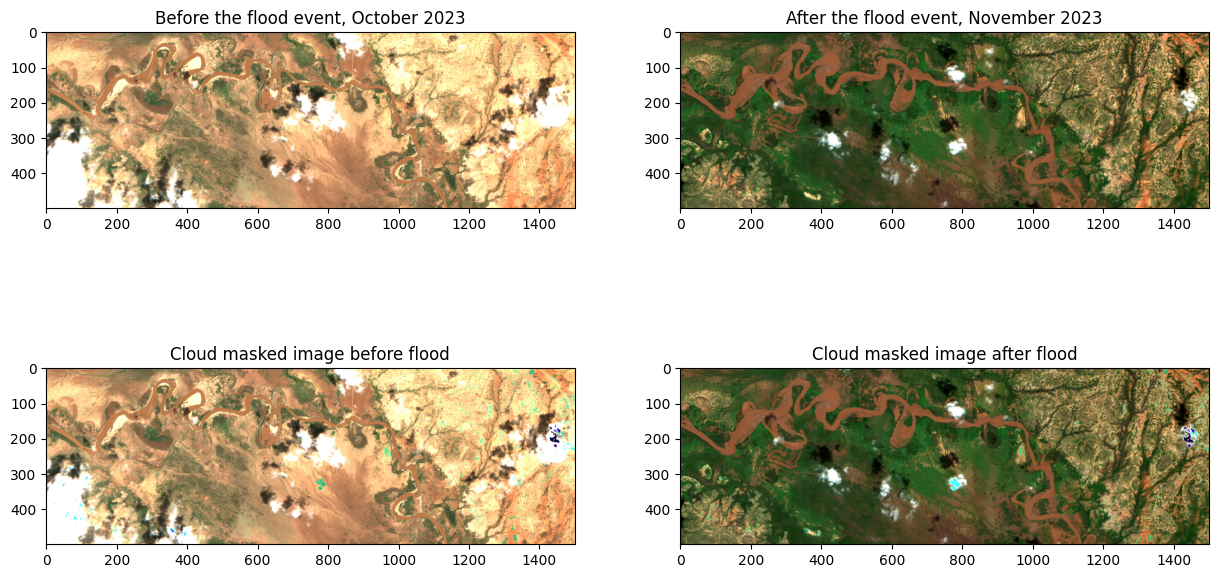

In [11]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.imshow(image_before_flood)
plt.title('Before the flood event, October 2023')

plt.subplot(2, 2, 2)
plt.imshow(image_after_flood)
plt.title('After the flood event, November 2023')

plt.subplot(2, 2, 3)
plt.imshow(masked_image_before_flood)
plt.title('Cloud masked image before flood')

plt.subplot(2, 2, 4)
plt.imshow(masked_image_after_flood)
plt.title('Cloud masked image after flood')

Calculate the flooded extent while comparing the two cloud free images

Calculate the absolute difference between the masked images


In [12]:
difference = cv2.absdiff(masked_image_before_flood, masked_image_after_flood)

In [13]:
gray_difference = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(gray_difference, 55, 255, cv2.THRESH_BINARY)


blue represents negative differences, white represents no difference, and red represents positive differences. 

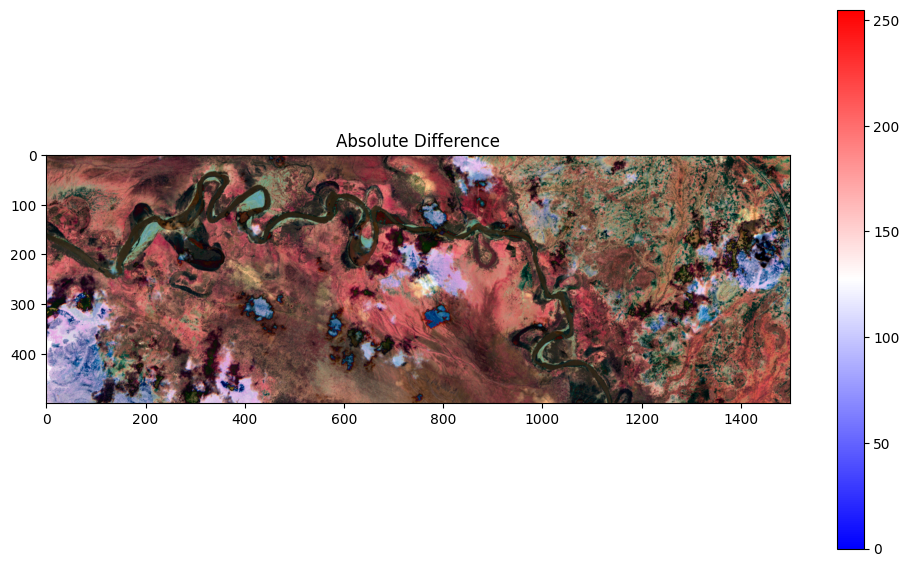

In [14]:
plt.figure(figsize=(12, 7))
plt.imshow(difference, cmap='bwr', vmin=np.min(difference), vmax=np.max(difference))  # Adjust vmin and vmax based on your data
plt.title('Absolute Difference')
plt.colorbar()

Find contours in the binary/thresholded image and mask them out to archive the pure flood extent

In [15]:
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# creates an empty binary image (flood_extent) with the same dimensions as the grayscale image gray_difference
flood_extent = np.zeros_like(gray_difference)

# Getting the contours on the flood_extent
cv2.drawContours(flood_extent, contours, -1, (255), thickness=cv2.FILLED)
# flooded extent: total number of pixels with values greater than 0 in the filled contour mask
flooded_extent = np.sum(flood_extent > 0)

total number of pixels which have been flooded

In [16]:
flooded_extent

638651

Visualize the difference image and flooded extent

Text(0.5, 1.0, 'Flooded Extent')

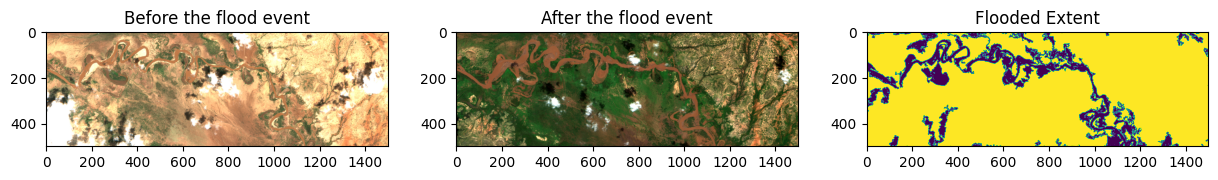

In [17]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_before_flood)
plt.title('Before the flood event')

plt.subplot(1, 3, 2)
plt.imshow(image_after_flood)
plt.title('After the flood event')

plt.subplot(1, 3, 3)
plt.imshow(flood_extent, cmap='viridis')
plt.title('Flooded Extent')



Plotting the pure flood extent

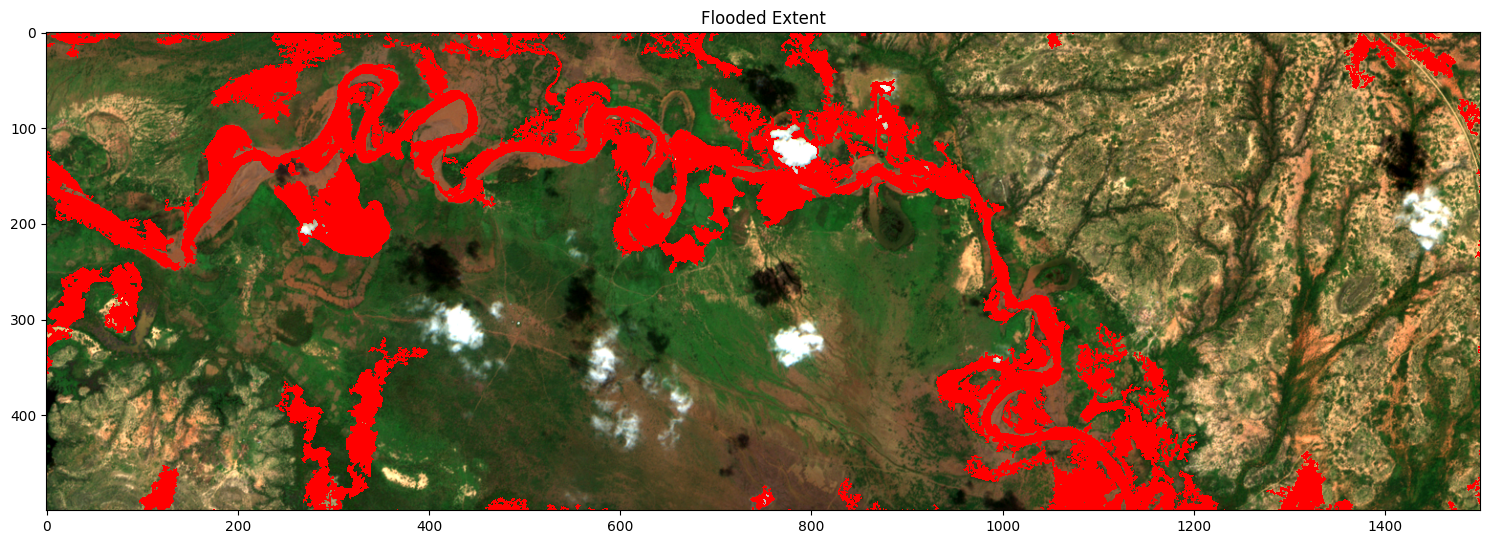

In [18]:

flood_extent_binary = np.where(0, np.nan, flood_extent)

plt.figure(figsize=(15, 15))
plt.imshow(image_after_flood, alpha=1.0) 
colors = ['red', 'blue']

cmap = ListedColormap(colors, name='custom_colormap', N=len(colors))
cmap.colors[1] = (0, 0, 0, 0)  # alpha (transparency) of the second class to 0

# Plot the binary layer with the custom colormap
plt.imshow(flood_extent_binary, cmap=cmap)

plt.title('Flooded Extent')

plt.tight_layout()  
plt.show()

## Using Sentinel 1

SAR's inherent capability to observe during cloud cover and Sentinel-1's frequent revisits makes it ideal for flood monitoring. It can be used to assess the extent of flooded areas and the impact on human, economic and environmental loss. Furthermore, high-resolution digital elevation models (DEMs) generated through Sentinel-1's interferometric modes can be used to conduct run-off and inundation analysis in areas previously lacking elevation data.

Calm open water surfaces appear flat when being hit by C-band SAR radiation, and the radiation is scattered away from the satellite’s sensor. Consequently, the received energy (measured as backscatter) is low and shows high contrast to general land surfaces. Generally, the underlying principle of the SAR-based flood mapping methods is to identify low backscatter measurements where land is expected under normal conditions. Two SAR polarisations (VV and VH) are required to allow a detection of flooded vegetation.

we use the EODAG to search for `S1_SAR_GRD`.  This product type stands for Sentinel-1 Synthetic Aperture Radar Ground Range Detected data, which are already corrected for terrain topography.  
  
We usethe same date range of the optical data before and after the flood event.

In [19]:
setup_logging(0)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((42.991562 6.035224, 42.991562 6.076534, 43.054047 6.076534, 43.054047 6.035224, 42.991562 6.035224))"
search_results_s1, total_count = dag.search(
    productType="S1_SAR_GRD",
    geom=geometry,
    start=start_dt,
    end=end_dt,
)

In [20]:
search_results_s1

SearchResult([EOProduct(id=S1A_IW_GRDH_1SDV_20231107T025406_20231107T025431_051105_0629BD_2462, provider=creodias_s3),
              EOProduct(id=S1A_IW_GRDH_1SDV_20231119T025406_20231119T025431_051280_062FCC_4E9D, provider=creodias_s3),
              EOProduct(id=S1A_IW_GRDH_1SDV_20231014T025406_20231014T025431_050755_061DC7_54C6, provider=creodias_s3),
              EOProduct(id=S1A_IW_GRDH_1SDV_20231201T025405_20231201T025430_051455_0635C6_1E14, provider=creodias_s3)])

Load, zoom and transpose, and quick look at the S1 data

In [21]:
search_results_s1 = sorted(search_results_s1, key=lambda x: datetime.strptime(x.properties.get("publicationDate", ""), '%Y-%m-%dT%H:%M:%S.%fZ'))
search_results_s1

[EOProduct(id=S1A_IW_GRDH_1SDV_20231014T025406_20231014T025431_050755_061DC7_54C6, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231107T025406_20231107T025431_051105_0629BD_2462, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231119T025406_20231119T025431_051280_062FCC_4E9D, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231201T025405_20231201T025430_051455_0635C6_1E14, provider=creodias_s3)]

list measured data

In [23]:
main_path = sandbox_project_root+ search_results_s1[0].properties['productIdentifier'] + '/measurement'
os.listdir(main_path)

['s1a-iw-grd-vh-20231014t025406-20231014t025431-050755-061dc7-002.tiff',
 's1a-iw-grd-vv-20231014t025406-20231014t025431-050755-061dc7-001.tiff']

Please note that the execution of the following code block can take up to 30 minutes.

In [24]:
search_results_kv_s1 = {}
for result in search_results_s1:
    # getting the date of aquisition
    publication_date_str = result.properties.get("startTimeFromAscendingNode", "")
    publication_date = datetime.strptime(publication_date_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    print(publication_date)
    main_path = sandbox_project_root+ result.properties['productIdentifier'] + '/measurement'
    if os.path.exists(main_path):
        s1 = glob(os.path.join(main_path, '*vv*'))[0]
        print(s1)
        with rio.open(s1) as src:
            s1_array = src.read()
            s1_array = np.flip(s1_array, axis=2)
            roi = s1_array[:, 6000:8500, 12000:20000] # zoom to the area of interest
        transposed_s1 = np.transpose(roi, (1, 2, 0))
        #plt.imshow(transposed_s1, cmap='gray', vmin=0, vmax=255)
        #plt.title(f'S1 GRD VV, Date: {publication_date_str}')
        #plt.show()
        search_results_kv_s1[result.properties["startTimeFromAscendingNode"]] = transposed_s1

2023-10-14 02:54:06.844000
/home/eoafrica/eodata/Sentinel-1/SAR/IW_GRDH_1S/2023/10/14/S1A_IW_GRDH_1SDV_20231014T025406_20231014T025431_050755_061DC7_54C6.SAFE/measurement/s1a-iw-grd-vv-20231014t025406-20231014t025431-050755-061dc7-001.tiff
2023-11-07 02:54:06.449000
/home/eoafrica/eodata/Sentinel-1/SAR/IW_GRDH_1S/2023/11/07/S1A_IW_GRDH_1SDV_20231107T025406_20231107T025431_051105_0629BD_2462.SAFE/measurement/s1a-iw-grd-vv-20231107t025406-20231107t025431-051105-0629bd-001.tiff
2023-11-19 02:54:06.439000
/home/eoafrica/eodata/Sentinel-1/SAR/IW_GRDH_1S/2023/11/19/S1A_IW_GRDH_1SDV_20231119T025406_20231119T025431_051280_062FCC_4E9D.SAFE/measurement/s1a-iw-grd-vv-20231119t025406-20231119t025431-051280-062fcc-001.tiff
2023-12-01 02:54:05.687000
/home/eoafrica/eodata/Sentinel-1/SAR/IW_GRDH_1S/2023/12/01/S1A_IW_GRDH_1SDV_20231201T025405_20231201T025430_051455_0635C6_1E14.SAFE/measurement/s1a-iw-grd-vv-20231201t025405-20231201t025430-051455-0635c6-001.tiff


 Analysing the flood event with S1

In [25]:
search_results_kv_s1.keys()

dict_keys(['2023-10-14T02:54:06.844Z', '2023-11-07T02:54:06.449Z', '2023-11-19T02:54:06.439Z', '2023-12-01T02:54:05.687Z'])

Choosing an image before and after the flood event

In [26]:
image_before_flood = [item for key, item in search_results_kv_s1.items() if "-10-" in key in key] # select one image in october before the event
image_after_flood = [item for key, item in search_results_kv_s1.items() if "-12-" in key in key] # select one image in december after the event

Calculating and plotting the differences of the images before and after the flood event. 

In [27]:
def plot_sentinel1_difference(before: np.ndarray, after: np.ndarray, threshold: float = 0.0):
    """
    Plot the difference between two Sentinel-1 images.

    Parameters:
    - before (np.ndarray): The Sentinel-1 image before the event.
    - after (np.ndarray): The Sentinel-1 image after the event.
    - threshold (float): Threshold value for highlighting changes (default is 0).

    Returns:
        None
    """
    # Checking that both arrays have the same shape
    if before and after: 
        before = before[0]
        after = after[0]
        min_rows = min(before.shape[0], after.shape[0])
        min_cols = min(before.shape[1], after.shape[1])

        before = before[:min_rows, :min_cols, :]
        after = after[:min_rows, :min_cols, :]
        difference = before - after

        # Apply thresholding to highlight changes
        #difference[difference <= threshold] = 0

        plt.figure(figsize=(20, 15))

        plt.subplot(1, 3, 1)
        plt.imshow(before, cmap='gray', vmin=0, vmax=255)
        plt.title('Before the flood')

        plt.subplot(1, 3, 2)
        plt.imshow(after, cmap='gray', vmin=0, vmax=255)
        plt.title('After the flood')

        plt.subplot(1, 3, 3)
        plt.imshow(difference, cmap='coolwarm')
        plt.title('Difference (After - Before)')
        plt.colorbar(shrink=0.1)

        plt.tight_layout()
        plt.show()
    else:
        print("There is no image before or after the event.")

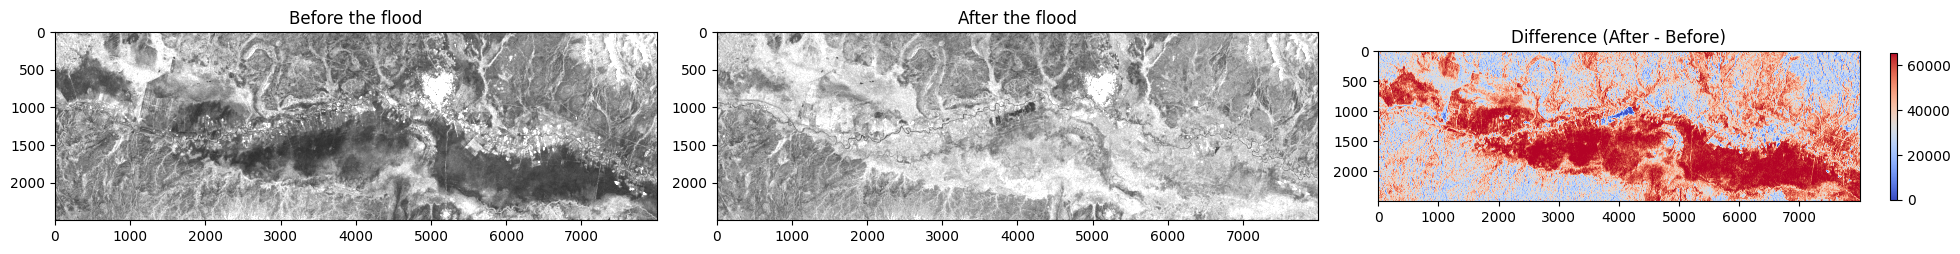

In [28]:
plot_sentinel1_difference(image_before_flood, image_after_flood, threshold = 0)

Blue regions indicate where the values in the "After Flood" image are lower than the corresponding values in the "Before Flood" image. Therefore, negative values are represented with blue/cool colors.

Red regions indicate where the values in the "After Flood" image are higher than the corresponding values in the "Before Flood" image. Therefore, positives values are represented with red/warm colors

Neutral colors (closer to white) represent areas where there is little to no difference between the two images.